# GAMMA RAY BURSTS

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

[]

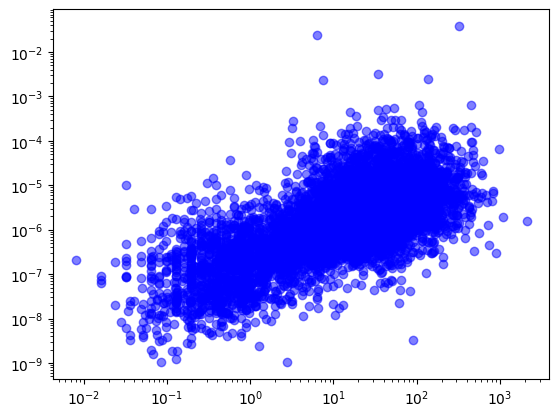

In [4]:
T90_vs_fluence = np.array([[data[6, i], data[9, i]] for i in range(len(data[0, :]))], dtype=float)
condition1 = (T90_vs_fluence[:,0] >= 0.0)
a = T90_vs_fluence[condition1]
condition2 = a[:, 1] >= 0.0
T90_vs_f_pos = a[condition2]
plt.scatter(T90_vs_f_pos[:, 0], T90_vs_f_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()

In [62]:
dir(np)

['ALLOW_THREADS',
 'BUFSIZE',
 'CLIP',
 'DataSource',
 'ERR_CALL',
 'ERR_DEFAULT',
 'ERR_IGNORE',
 'ERR_LOG',
 'ERR_PRINT',
 'ERR_RAISE',
 'ERR_WARN',
 'FLOATING_POINT_SUPPORT',
 'FPE_DIVIDEBYZERO',
 'FPE_INVALID',
 'FPE_OVERFLOW',
 'FPE_UNDERFLOW',
 'False_',
 'Inf',
 'Infinity',
 'MAXDIMS',
 'MAY_SHARE_BOUNDS',
 'MAY_SHARE_EXACT',
 'NAN',
 'NINF',
 'NZERO',
 'NaN',
 'PINF',
 'PZERO',
 'RAISE',
 'RankWarning',
 'SHIFT_DIVIDEBYZERO',
 'SHIFT_INVALID',
 'SHIFT_OVERFLOW',
 'SHIFT_UNDERFLOW',
 'ScalarType',
 'True_',
 'UFUNC_BUFSIZE_DEFAULT',
 'UFUNC_PYVALS_NAME',
 'WRAP',
 '_CopyMode',
 '_NoValue',
 '_UFUNC_API',
 '__NUMPY_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__config__',
 '__deprecated_attrs__',
 '__dir__',
 '__doc__',
 '__expired_functions__',
 '__file__',
 '__former_attrs__',
 '__future_scalars__',
 '__getattr__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_add_newdoc_ufunc',
 '_builtins',
 '_core',
 '_distributor_init',
